In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords
from sklearn.metrics import log_loss


stopwords = stopwords.words('english')
sns.set_context('notebook')
from nltk.corpus import gutenberg, stopwords
from collections import Counter

np.random.seed(27)

In [2]:
plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22})

sns.set_palette('bright')
sns.set_style('whitegrid')
sns.set_context('talk')

In [3]:
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')
emma = gutenberg.raw('austen-emma.txt')

In [4]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
emma = re.sub(r'CHAPTER .*', '', emma)
emma = re.sub(r'VOLUME \w+', '', emma)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)
emma = text_cleaner(emma)

In [5]:
# Parse the cleaned novels.
nlp = spacy.load('en')

alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)
emma_doc = nlp(emma)

In [6]:
# Group into sentences.
alice_sents = [[sent, 'Alice', 'Carrol'] for sent in nltk.sent_tokenize(alice)]
persuasion_sents = [[sent, 'Persuasion', "Austen"] for sent in nltk.sent_tokenize(persuasion)]
emma_sents = [[sent, 'Emma', "Austen"] for sent in nltk.sent_tokenize(emma)]

In [46]:
# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents + emma_sents, columns=['Sentence', 'Text', 'Author'])
sentences.sample(5)

,Sentence,Text,Author
5808,I think her the very worst sort of companion t...,Emma,Austen
11152,"said she, with a conscious look.",Emma,Austen
10061,"You will laugh at my warmth but, upon my word,...",Emma,Austen
5956,I could not help being provoked; for after all...,Emma,Austen
6682,"I wonder which she will think the handsomest, ...",Emma,Austen


In [29]:
sentences.Author.value_counts()

Austen    12360
Carrol     1625
Name: Author, dtype: int64

In [30]:
sentences.Text.value_counts()

Emma          8703
Persuasion    3657
Alice         1625
Name: Text, dtype: int64

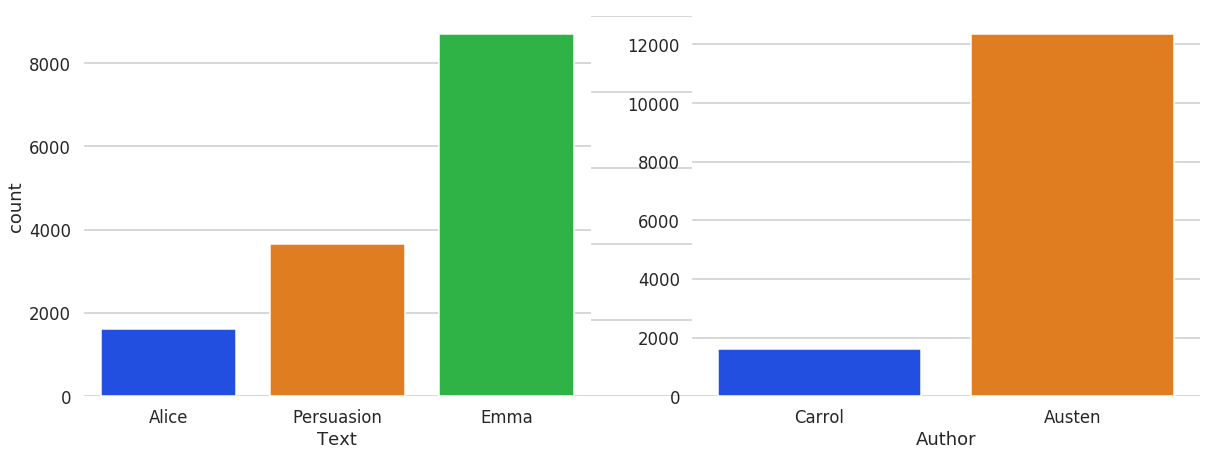

In [8]:
fig, ax = plt.subplots()

fig.add_subplot(121)
sns.countplot(sentences.Text)

fig.add_subplot(122)
sns.countplot(sentences.Author)

ax.set_xticklabels('')
plt.ylabel('')
ax.set_yticklabels('')

sns.despine(left=True, bottom=True)

plt.show();

In [9]:
# Clean text before feeding it to spaCy
punctuations = string.punctuation

stop_words = set(stopwords.words("english"))

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stop_words and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [10]:
# Grab all text associated with Alice
alice_text = [text for text in sentences[sentences['Text'] == 'Alice']['Sentence']]

# Grab all text associated with Persuasion
persuasion_text = [text for text in sentences[sentences['Text'] == 'Persuasion']['Sentence']]

# Grab all text associated with Emma
emma_text = [text for text in sentences[sentences['Text'] == 'Emma']['Sentence']]

In [11]:
# Clean up all text
alice_clean = cleanup_text(alice_text)
alice_clean = ' '.join(alice_clean).split()
# 's appears a lot in the text, so we get rid of it since it's not a word
alice_clean = [word for word in alice_clean if word != '\'s']

persuasion_clean = cleanup_text(persuasion_text)
persuasion_clean = ' '.join(persuasion_clean).split()
# 's appears a lot in the text, so we get rid of it since it's not a word
persuasion_clean = [word for word in persuasion_clean if word != '\'s']

emma_clean = cleanup_text(emma_text)
emma_clean = ' '.join(emma_clean).split()
# 's appears a lot in the text, so we get rid of it since it's not a word
emma_clean = [word for word in emma_clean if word != '\'s']

In [12]:
# Count all unique words
alice_counts = Counter(alice_clean)
persuasion_counts = Counter(persuasion_clean)
emma_counts = Counter(emma_clean)

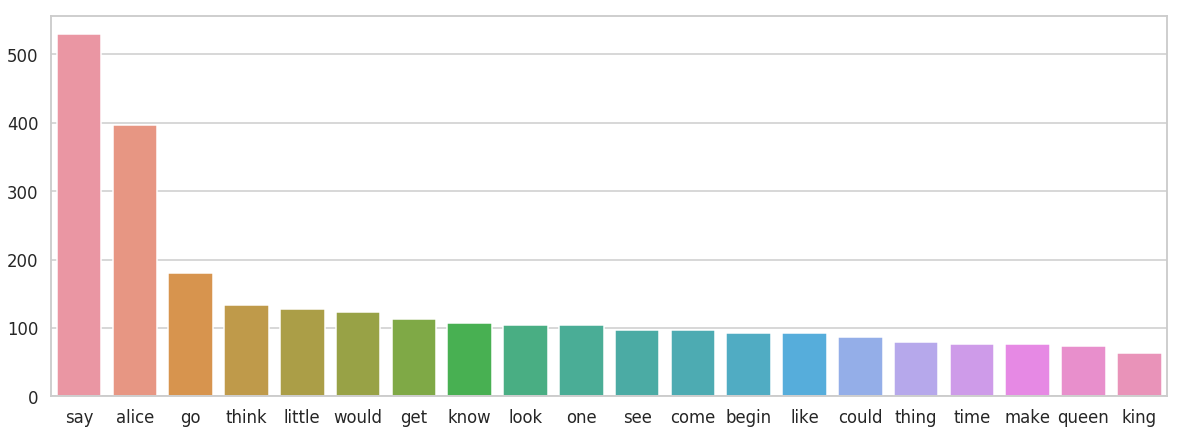

In [13]:
alice_common_words = [word[0] for word in alice_counts.most_common(20)]
alice_common_counts = [word[1] for word in alice_counts.most_common(20)]

sns.barplot(alice_common_words, alice_common_counts);

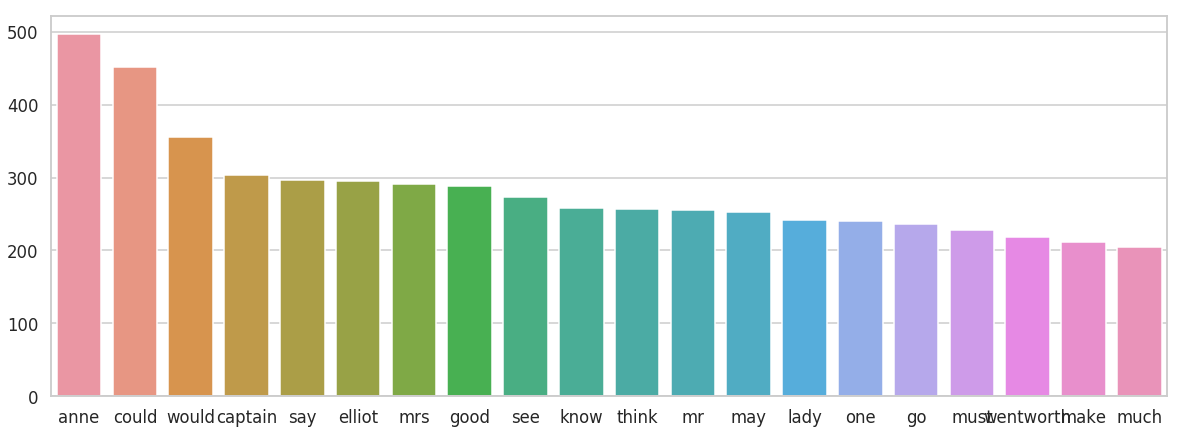

In [14]:
persuasion_common_words = [word[0] for word in persuasion_counts.most_common(20)]
persuasion_common_counts = [word[1] for word in persuasion_counts.most_common(20)]

sns.barplot(persuasion_common_words, persuasion_common_counts);

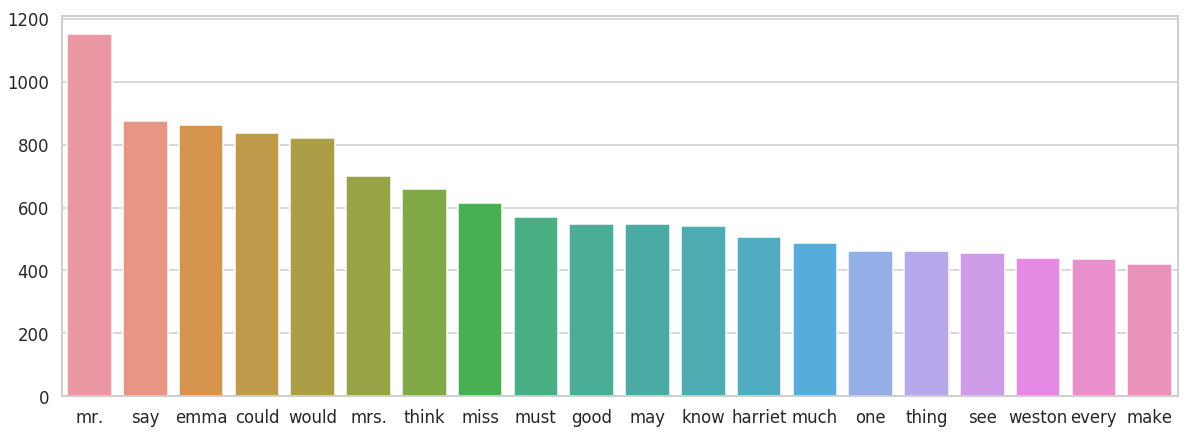

In [15]:
emma_common_words = [word[0] for word in emma_counts.most_common(20)]
emma_common_counts = [word[1] for word in emma_counts.most_common(20)]

sns.barplot(emma_common_words, emma_common_counts);

In [16]:
sentences['Sentence'] = cleanup_text(sentences['Sentence'], logging=True)

Processed 1000 out of 13985 documents.
Processed 2000 out of 13985 documents.
Processed 3000 out of 13985 documents.
Processed 4000 out of 13985 documents.
Processed 5000 out of 13985 documents.
Processed 6000 out of 13985 documents.
Processed 7000 out of 13985 documents.
Processed 8000 out of 13985 documents.
Processed 9000 out of 13985 documents.
Processed 10000 out of 13985 documents.
Processed 11000 out of 13985 documents.
Processed 12000 out of 13985 documents.
Processed 13000 out of 13985 documents.


In [17]:
sentences.head()

,Sentence,Text,Author
0,alice begin get tired sit sister bank nothing ...,Alice,Carrol
1,consider mind well could hot day make feel sle...,Alice,Carrol
2,nothing remarkable alice think much way hear r...,Alice,Carrol
3,oh dear,Alice,Carrol
4,shall late,Alice,Carrol


In [18]:
# Parse documents and print some info
print('Parsing documents...')

start = time()

train_vec = []
for doc in nlp.pipe(sentences['Sentence'], batch_size=500):
    if doc.has_vector:
        train_vec.append(doc.vector)
    # If doc doesn't have a vector, then fill it with zeros.
    else:
        train_vec.append(np.zeros((128,), dtype="float32"))
        

#sentences['sentence_vec'] = train_vec
vector = np.array(train_vec)
end = time()
print('Total time passed parsing documents: {} seconds'.format(end - start))
print('Total number of documents parsed: {}'.format(len(train_vec)))

sentences.head()

Parsing documents...
Total time passed parsing documents: 24.56984305381775 seconds
Total number of documents parsed: 13985


,Sentence,Text,Author
0,alice begin get tired sit sister bank nothing ...,Alice,Carrol
1,consider mind well could hot day make feel sle...,Alice,Carrol
2,nothing remarkable alice think much way hear r...,Alice,Carrol
3,oh dear,Alice,Carrol
4,shall late,Alice,Carrol


In [19]:
vector.shape

(13985, 128)

In [20]:
vector_df = pd.DataFrame(vector)
vector_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.985106,0.283589,0.789392,1.005349,0.323456,0.590381,-3.007998,-0.433441,1.219401,0.804422,...,1.748973,0.736352,1.176759,-0.201412,1.332310,0.959739,2.291510,-1.203328,1.995070,-2.454606
1,0.824024,-0.017829,0.458632,0.894168,0.015317,0.586833,-1.825552,-0.144942,0.764444,0.699600,...,1.671695,-0.013963,1.372033,0.080689,1.702708,-0.214233,0.812344,-0.722838,1.578433,-1.533563
2,-0.277408,0.258219,1.229327,0.146081,0.069124,0.585479,-1.723399,0.555170,0.047979,1.036819,...,0.672791,-0.039413,2.379755,0.659325,1.647708,0.660287,1.826175,-0.525239,1.430477,-1.425846
3,-1.288907,-0.592735,-0.386497,1.396173,-0.007671,1.139815,-0.396110,3.687816,-0.208923,1.519778,...,0.139092,-1.922554,3.067594,-0.912898,0.290471,0.716767,0.420478,1.095417,0.018182,1.046853
4,0.438130,0.648610,-0.734902,-0.072902,-1.963023,1.025945,-0.974629,1.619319,1.889651,1.522309,...,1.248711,-1.406428,-1.488199,1.643352,2.238344,-1.882067,-0.793130,0.755059,-0.054361,-0.211128


In [21]:
from sklearn.preprocessing import label_binarize

hot_authors = label_binarize(sentences['Author'], classes=['Carrol', 'Austen'])
hot_books = label_binarize(sentences['Text'], classes=['Alice', 'Persuasion', 'Emma'])

In [24]:
from sklearn.model_selection import train_test_split

X_train_authors, X_test_authors, y_train_authors, y_test_authors = train_test_split(vector_df, hot_authors, test_size=0.2)

In [25]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()

train_authors = rfc.fit(X_train_authors, y_train_authors)

print('Training set score:', rfc.score(X_train_authors, y_train_authors))
print('\nTest set score:', rfc.score(X_test_authors, y_test_authors))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Training set score: 0.9896317483017518

Test set score: 0.8880943868430461


It looks like the model is overfitting.  Let's see if we try balancing the classes if we can increase our accuracy.

In [57]:
sentences.Author.value_counts()

Austen    12360
Carrol     1625
Name: Author, dtype: int64

In [58]:
## upsampling minority class
from sklearn.utils import resample

carrol = sentences[sentences.Author == 'Carrol']
austen = sentences[sentences.Author == 'Austen']

# upsample minority
authors_upsampled = resample(carrol,
                                replace = True, # sample with replacement
                                n_samples = 12360, # match majority n
                                random_state = 27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([authors_upsampled, austen])

# checking counts
upsampled.Author.value_counts()

Austen    12360
Carrol    12360
Name: Author, dtype: int64

In [59]:
hot_authors_upsampled = label_binarize(upsampled['Author'], classes=['Carrol', 'Austen'])

In [64]:
# Parse documents and print some info
print('Parsing documents...')

start = time()

train_vec = []
for doc in nlp.pipe(upsampled['Sentence'], batch_size=500):
    if doc.has_vector:
        train_vec.append(doc.vector)
    # If doc doesn't have a vector, then fill it with zeros.
    else:
        train_vec.append(np.zeros((128,), dtype="float32"))
        

#sentences['sentence_vec'] = train_vec
upsampled_vector = np.array(train_vec)
end = time()
print('Total time passed parsing documents: {} seconds'.format(end - start))
print('Total number of documents parsed: {}'.format(len(train_vec)))

print(upsampled_vector.shape)

upsampled_vector_df = pd.DataFrame(upsampled_vector)
upsampled_vector_df.head()

Parsing documents...
Total time passed parsing documents: 103.6523129940033 seconds
Total number of documents parsed: 24720
(24720, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.075821,0.606573,0.016820,1.748084,0.373850,0.488610,-0.987244,-0.581527,1.179195,0.228671,...,0.011281,-1.215931,-0.069679,0.256787,0.908127,0.640685,-0.832860,-0.900140,0.624743,0.016150
1,0.448118,-0.195631,0.073487,1.514236,0.272957,-0.014527,0.073963,-0.360488,0.629624,0.647903,...,-0.175945,-1.573335,0.258876,0.546142,-0.396142,-0.590228,-0.044849,-1.396215,0.789826,-0.500126
2,-0.731779,-0.710765,1.350872,-0.363419,0.946535,0.403027,-0.053424,-1.800714,-0.308160,-1.074942,...,0.055141,-0.935350,0.217662,1.745616,-0.705720,0.028631,-0.910157,-1.675002,1.658085,-0.298109
3,0.396850,0.613532,0.124598,2.148331,-0.171681,1.211462,-1.383646,-0.495583,1.283045,0.442520,...,-0.126024,-0.675997,0.091399,0.529434,0.242320,-1.027671,-0.360377,-1.520260,1.077204,-0.614596
4,0.386541,1.171450,0.034682,1.752047,0.693385,0.459411,-0.575027,0.731775,0.158648,-0.202065,...,-0.406579,-1.469008,0.271545,-0.517344,0.192837,-0.022749,-0.915515,0.286142,1.344913,-0.115322


In [65]:
print(upsampled_vector.shape)

(24720, 128)


In [66]:
X_train_authors, X_test_authors, y_train_authors, y_test_authors = train_test_split(upsampled_vector_df, hot_authors_upsampled, test_size=0.2)

In [67]:
train_authors_upsampled = rfc.fit(X_train_authors, y_train_authors)

print('Training set score:', rfc.score(X_train_authors, y_train_authors))
print('\nTest set score:', rfc.score(X_test_authors, y_test_authors))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


Training set score: 0.9992415048543689

Test set score: 0.9908980582524272


Much better!  After upsampling the minority class we got a much better score for the test set!  Now lets see if we can predict the books accurately.

In [26]:
X_train_books, X_test_books, y_train_books, y_test_books = train_test_split(vector_df, hot_books, test_size=0.2)

In [27]:
train_books = rfc.fit(X_train_books, y_train_books)

print('Training set score: ', rfc.score(X_train_books, y_train_books))
print('\nTest set score: ', rfc.score(X_test_books, y_test_books))

Training set score:  0.9427958526993206

Trest set score:  0.48158741508759384


This isn't looking too good.  Let's see if we use the upsampled data from above if that will increase the score.

In [68]:
sentences.Text.value_counts()

Emma          8703
Persuasion    3657
Alice         1625
Name: Text, dtype: int64

In [69]:
hot_books_upsampled = label_binarize(upsampled['Text'], classes=['Emma', 'Persuasion', 'Alice'])

In [70]:
X_train_books, X_test_books, y_train_books, y_test_books = train_test_split(upsampled_vector_df, hot_books_upsampled, test_size=0.2)

In [71]:
train_books = rfc.fit(X_train_books, y_train_books)

print('Training set score: ', rfc.score(X_train_books, y_train_books))
print('\nTest set score: ', rfc.score(X_test_books, y_test_books))

Training set score:  0.982200647249191

Test set score:  0.7497977346278317


It's performing much better, but still overfitting.